In [2]:
import os
from pfca import init_path
from pfca.visuals.img2D import imgplot

Current Working Directory: /Users/shwetankpanwar/Documents/BTPData/python_scripts/cmb_segmentation
The file structure creation failed. Structure already exists!


In [3]:
from pfca.visuals.plot3D import *

In [4]:
from pfca.core.preprocessing import *

In [5]:
from pfca.core.processing import *

In [6]:
from pfca import file_read as f
import ants

In [7]:
raw_dir, nifti_dir = init_path()
cur_path = os.getcwd()
patients_list = f.get_immediate_subdirectories(raw_dir)
patient = patients_list[0]

In [8]:
im_nifti = nifti_ANTS(nifti_dir, patient, category = 'eswan', unskulled = True)
im_patient = mni_template_registration(cur_path, im_nifti, patient)

In [9]:
#testing for template exclusion idea for anatomical exclusion to reduce search space
talariach = ants.image_read(cur_path + '/datasets/talairach.nii')
mni_t2 = ants.image_read(cur_path + '/datasets/mni_t2_template.nii')
harvard_atlas = ants.image_read(cur_path + '/datasets/harvard_atlas.nii')

In [10]:
talariach

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (141, 172, 110)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (70.0, 102.0, -42.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [11]:
im_patient

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [12]:
mni_t2

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [13]:
harvard_atlas

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [14]:
#Registering Harvard-Oxford Atlas with MNI-152 template using non-linear registration
harvard_mni = mni_template_registration(cur_path,harvard_atlas,'harvard')

In [15]:
harvard_mni

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

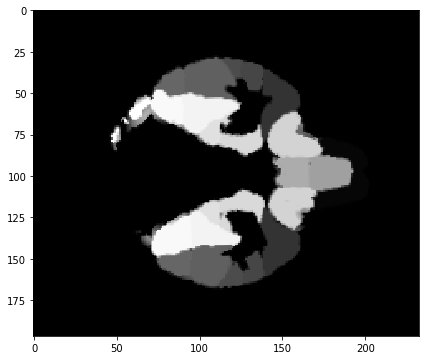

In [16]:
imgplot(harvard_mni, slice_no=[45])

In [17]:
#generating cortex mask from the atlas excluding all the regions of cerebrum 
harvard_mni_mask = ((harvard_mni.numpy()) > 0)*1

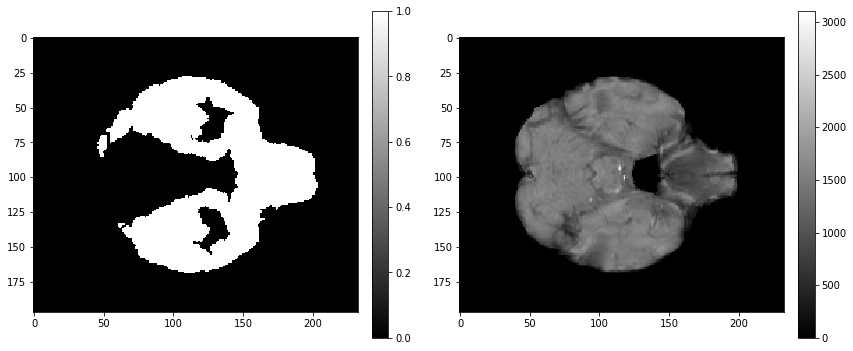

In [18]:
imgplot(harvard_mni_mask, im_patient, slice_no=[45,45])

In [19]:
cortex_regions = harvard_mni_mask * im_patient.numpy()

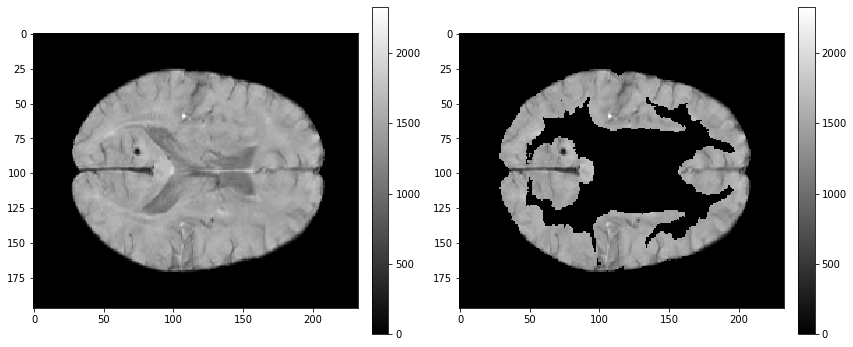

In [42]:
imgplot(im_patient, cortex_regions, slice_no=[85,85])

In [21]:
#Plot the cortex regions of the brain using the plot_brain function
plot_brain(cortex_regions)

In [30]:
#Calculating the rst output on the cortex image
rst_out = rst_3d(cortex_regions,2,2,0.2)

Time taken for 3D RST: 8.39000391960144


In [31]:
#calculating the RST output on the whole image
img_pat = im_patient.numpy()
rst_whole = rst_3d(img_pat, 2,2,0.2)

Time taken for 3D RST: 21.44982099533081


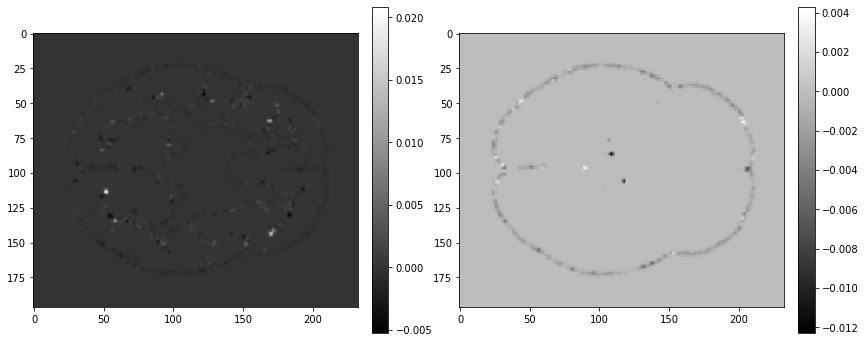

In [32]:
imgplot(rst_out,rst_whole,slice_no=[65,65])

In [25]:
#many false points are generated in the RST on the cortex image...so its better to apply mask on the rst_whole

In [33]:
rst_masked = rst_whole * harvard_mni_mask

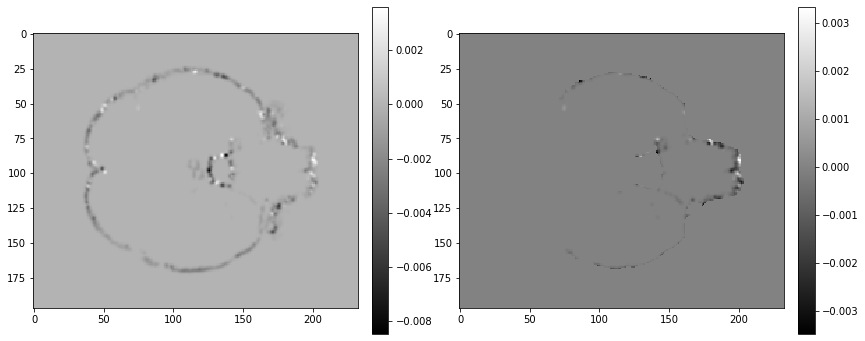

In [34]:
imgplot(rst_whole, rst_masked, slice_no=[45,45])

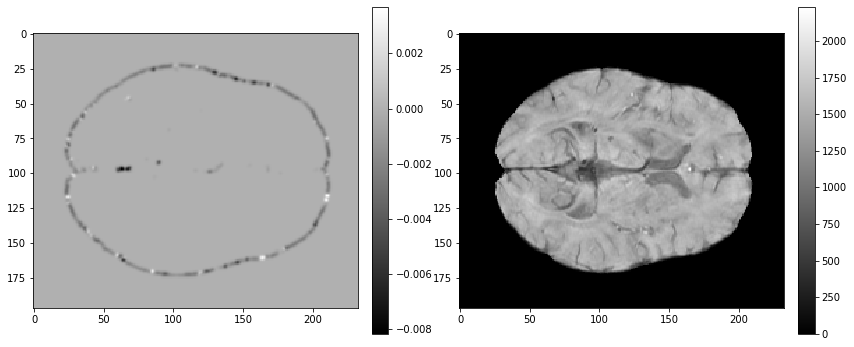

In [39]:
imgplot(rst_whole, img_pat, slice_no=[75,75])

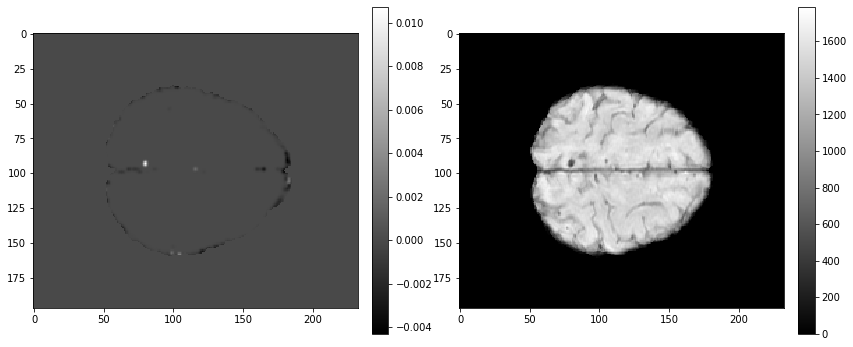

In [53]:
imgplot(rst_masked, img_pat, slice_no = [128,128])

In [49]:
#Extracting the candidate points from the RST output image
import skimage.feature as feature
from time import time
t1 = time()
peaks = feature.peak_local_max(rst_masked, min_distance=2,threshold_rel = 0.2)
t2 = time()
print("Time taken to find local maxima: " + str(t2-t1))

Time taken to find local maxima: 0.22167706489562988


In [50]:
peaks

array([[ 97,  91,  97],
       [ 93,  80, 128],
       [ 84,  74,  85],
       [ 53,  63,  96]])

In [ ]:
#Next step is to cluster the regions with similar intensity levels....This can be a very simple
#clustering method where we can just cluster the regions around the microbleed with similar intensity levels


In [59]:
#Snipping out the cubical 3D region out of the candidate detection based on local peaks
def roi_snipping(image,peaks,r):
    import numpy as np
    roi_array = []  #list in which all the roi images will be stored
    for i in range(len(peaks)):
        p = peaks[i]
        temp = image[p[0]-r:p[0]+r, p[1]-r:p[1]+r, p[2]-r:p[2]+r]
        roi_array.append(temp)
    return roi_array    

In [72]:
snips = roi_snipping(img_pat,peaks,10)

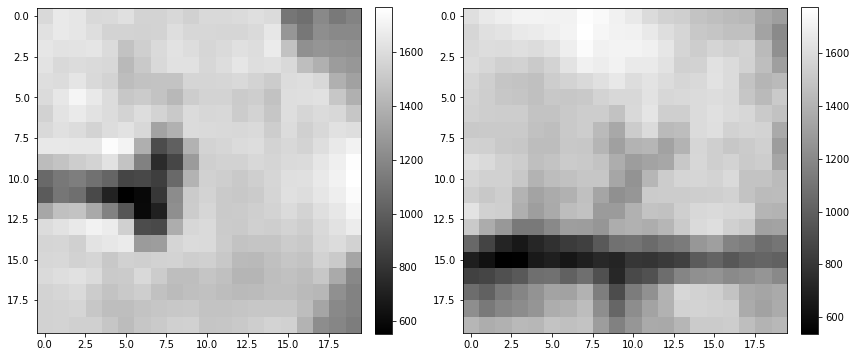

In [73]:
imgplot(snips[0], snips[1], slice_no=[4,4])

In [120]:
#draw ROI on the images and display the results
def draw_roi(image,peaks,r):
    ##Arguments:
    # image : 3D image on which the labelling is needed to be done
    # peaks : array containing the list of local maximas
    # r     : radius of the ROI bounding box
    import os
    import datetime
    from matplotlib import pyplot as plt
    from skimage.draw import rectangle_perimeter
    import matplotlib.patches as mpathches
    cur_path = os.getcwd()
    name = str((datetime.datetime.now()).strftime("%d%m%Y_%H%M%S")) + '.png'
    n = len(peaks)
    grid_n = int(n/2 if n%2 == 0 else ((n+1)/2))
    
    plt.figure(figsize = (12,14))
    for i in range(n):    
        p = peaks[i]
        temp = image[:,:,p[2]]
        plt.subplot(grid_n,2,i+1)
        plt.imshow(temp, cmap = plt.get_cmap('gray'))
        ax = plt.gca()
        rect = mpathches.Rectangle((p[1]-r, p[0]-r), 2*r, 2*r,
                                  fill= False, edgecolor = 'red', linewidth = 1)
        ax.add_patch(rect)
        #ax.set_axis_off()
    plt.tight_layout() 
    plt.savefig(cur_path + '/visuals/stills_2d/' + name)
    plt.show()

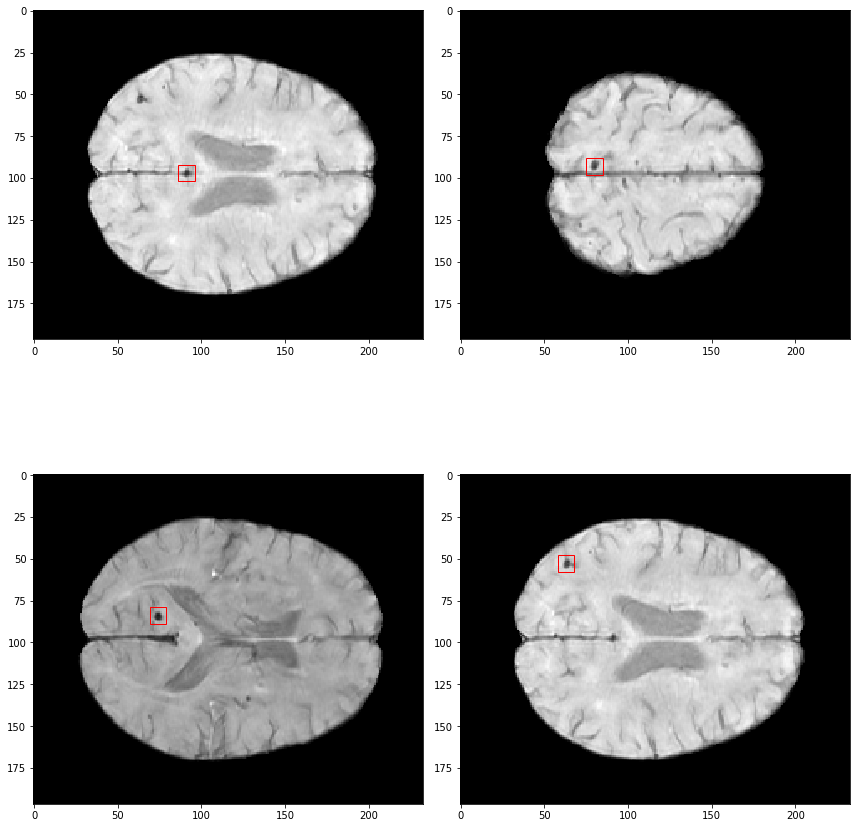

In [119]:
draw_roi(img_pat,peaks,5)